In [33]:
%matplotlib inline
import os
import pickle
import numpy as np
from matplotlib import pyplot as plt
from collections import OrderedDict


def get_default_args():
    args = OrderedDict()
    args['dataset'] = 'cifar10'
    args['data_augmentation'] = 'True'
    args['seed'] = 1
    args['sorting_file'] = 'none'
    args['remove_percent'] = 30
    args['burn_in_epochs'] = 50
    args['remove_strategy'] = 'unforgettable'
    args['noise_percent_labels'] = 0
    return args

def get_fname_from_args(args):
    fname = '__'.join("{}_{}".format(arg, args[arg]) for arg in args)
    return fname

def get_stats(data_dir, **kwargs):
    args = get_default_args()
    for key in kwargs:
        args[key] = kwargs[key]
    saved_fname = get_fname_from_args(args)
    fname = os.path.join(data_dir, saved_fname) + '__stats_dict.pkl'
    with open(fname, 'rb') as fin:
        unpickler = pickle.Unpickler(fin)
        data_stats = unpickler.load()
    return data_stats

def get_flipped_data(data_dir, **kwargs):
    args = get_default_args()
    for key in kwargs:
        args[key] = kwargs[key]
    saved_fname = get_fname_from_args(args)
    fname = os.path.join(data_dir, saved_fname) + '_changed_labels.txt'
    indexes = []
    with open(fname, 'rb') as fin:
        for line in fin:
            indexes.append(int(line.split()[0]))
    return np.array(indexes)


TODO:
- noisy pixel cifar10
- unbalanced mnist
- sampling method / soft forgetting
- speed up training procedure
- compare with/without assign maximum forgetting counting


50000


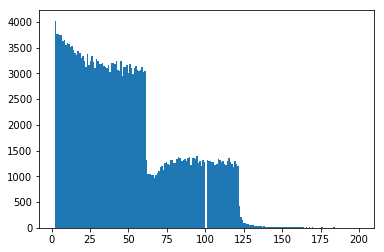

In [21]:
def draw_events_distribution():
    epochs = 200
    data_stats = get_stats('./online_results', burn_in_epochs=epochs, remove_strategy='random')

    forgetting_happens = []
    # iterate on every example
    for example_id, example_stats in data_stats.items():
        # skip 'train' and 'test' keys of diag_stats
        if not isinstance(example_id, str):
            # forgetting event is a transition in accuracy from 1 to 0
            presentation_acc = np.array(example_stats[1][:epochs])
            transitions = presentation_acc[1:] - presentation_acc[:-1]
            forgetting_epoch_idx = np.where(transitions == -1)[0] + 2
            forgetting_happens.append(forgetting_epoch_idx)            
    print(len(forgetting_happens))
    result = np.concatenate(forgetting_happens)
    plt.hist(result, bins=epochs)
    plt.show()

draw_events_distribution()

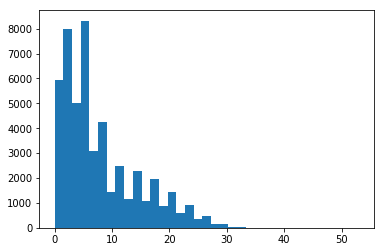

number of example that never learn: 0


In [73]:
def draw_example_distribution():
    epochs = 200
    data_stats = get_stats('./online_results', noise_percent_labels=30, remove_strategy='unforgettable')
    
    forgetting_counting = [0] * 50000
    example_never_learn = 0
    for example_id, example_stats in data_stats.items():
        if not isinstance(example_id, str):
            presentation_acc = np.array(example_stats[1][:epochs])
            transitions = presentation_acc[1:] - presentation_acc[:-1]
            forgetting_epoch_idx = np.where(transitions == -1)[0]
            forgetting_counting[example_id] = len(forgetting_epoch_idx)
            if np.count_nonzero(presentation_acc) == 0:
                example_never_learn += 1
    plt.hist(forgetting_counting, bins=35)
    plt.show()
    print('number of example that never learn: {0}'.format(example_never_learn))

draw_example_distribution()

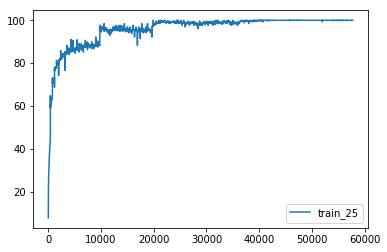

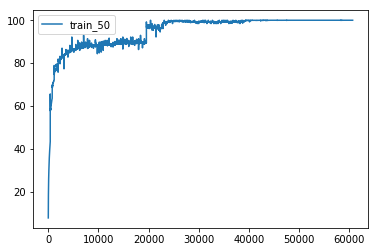

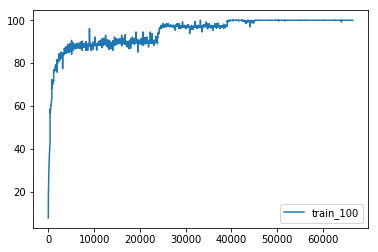

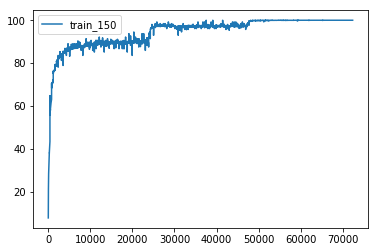

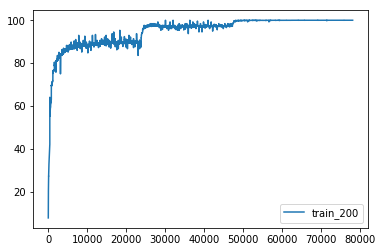

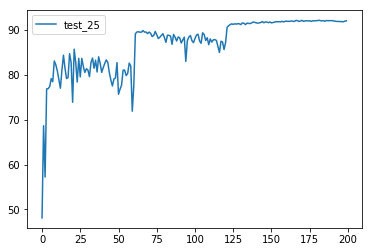

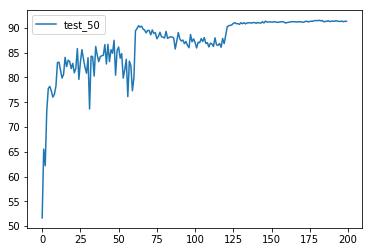

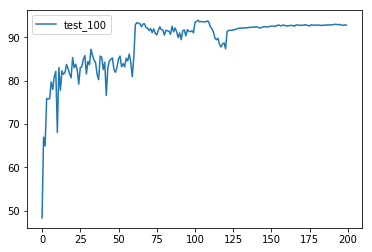

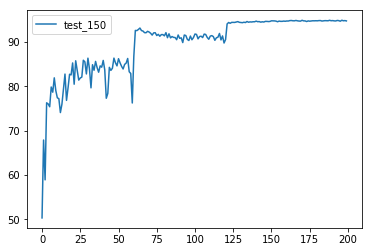

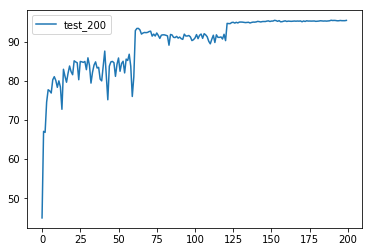

The best accuracy with burn_in_epochs=25: 92.15
The best accuracy with burn_in_epochs=50: 91.56
The best accuracy with burn_in_epochs=100: 93.91
The best accuracy with burn_in_epochs=150: 94.92
The best accuracy with burn_in_epochs=200: 95.44


In [31]:
def compare_online_different_burn_in_epochs():
    result_dir = './online_results'
    cnt = 1
    for epochs in [25, 50, 100, 150, 200]:
        data_stats = get_stats(result_dir, burn_in_epochs=epochs)
        plt.figure(cnt)
        plt.plot(data_stats['train'][1], label='train_' + str(epochs))
        cnt += 1
        plt.legend()
    for epochs in [25, 50, 100, 150, 200]:
        data_stats = get_stats(result_dir, burn_in_epochs=epochs)
        plt.figure(cnt)
        plt.plot(data_stats['test'][1], label='test_' + str(epochs))
        cnt += 1
        plt.legend()

    plt.show()
    
    for epochs in [25, 50, 100, 150, 200]:
        data_stats = get_stats(result_dir, burn_in_epochs=epochs)
        best_acc = np.max(data_stats['test'][1])
        print('The best accuracy with burn_in_epochs={0}: {1}'.format(epochs, best_acc))
    
compare_online_different_burn_in_epochs()

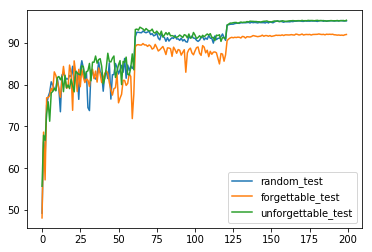

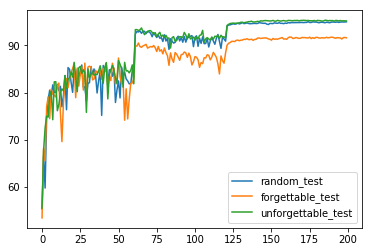

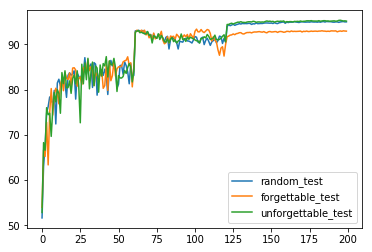

In [40]:
def compare_online_different_remove_strategy():
    # compare different remove mode: random, forgettable, unforgettable
    result_dir = './online_results'
    for cnt, epochs in enumerate([25, 50, 100]):
        random_stats = get_stats(result_dir, burn_in_epochs=epochs, remove_strategy='random')
        forgettable_stats = get_stats(result_dir, burn_in_epochs=epochs, remove_strategy='forgettable')
        unforgettable_stats = get_stats(result_dir, burn_in_epochs=epochs, remove_strategy='unforgettable')

    
        plt.figure(cnt)
        plt.plot(random_stats['test'][1], label='random_test')
        plt.plot(forgettable_stats['test'][1], label='forgettable_test')
        plt.plot(unforgettable_stats['test'][1], label='unforgettable_test')

        plt.legend()
    plt.show()
    
compare_online_different_remove_strategy()

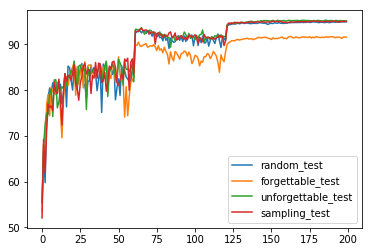

In [9]:
def compare_online_different_remove_strategy():
    # compare different remove mode: random, forgettable, unforgettable
    result_dir = './online_results'
    for cnt, epochs in enumerate([50]):
        random_stats = get_stats(result_dir, burn_in_epochs=epochs, remove_strategy='random')
        forgettable_stats = get_stats(result_dir, burn_in_epochs=epochs, remove_strategy='forgettable')
        unforgettable_stats = get_stats(result_dir, burn_in_epochs=epochs, remove_strategy='unforgettable')
        sampling_stats = get_stats(result_dir, burn_in_epochs=epochs, remove_strategy='sampling')

    
        plt.figure(cnt)
        plt.plot(random_stats['test'][1], label='random_test')
        plt.plot(forgettable_stats['test'][1], label='forgettable_test')
        plt.plot(unforgettable_stats['test'][1], label='unforgettable_test')
        plt.plot(sampling_stats['test'][1], label='sampling_test')

        plt.legend()
    plt.show()
    
compare_online_different_remove_strategy()

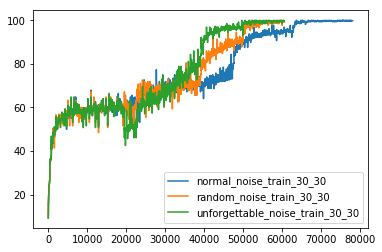

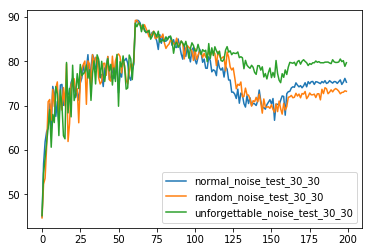

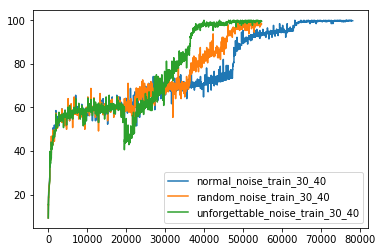

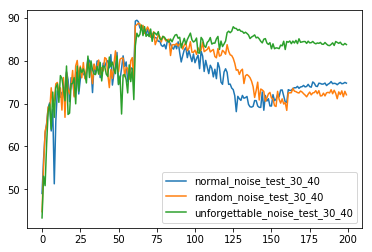

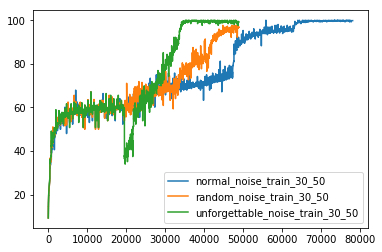

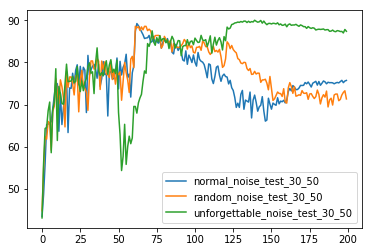

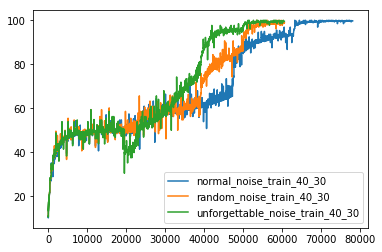

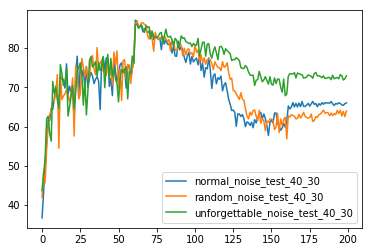

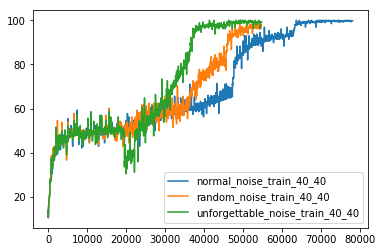

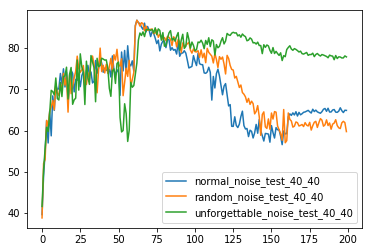

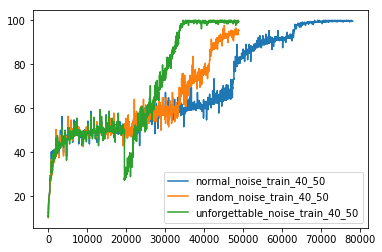

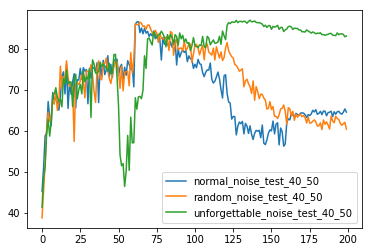

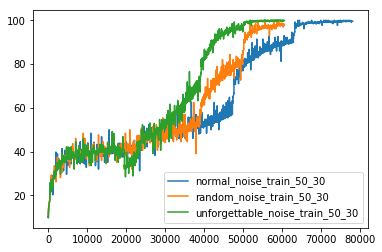

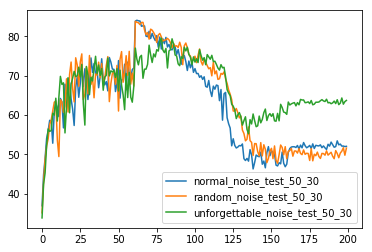

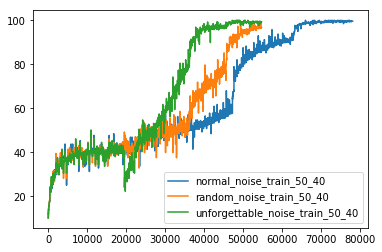

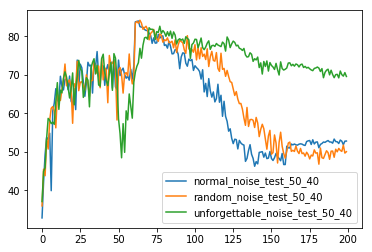

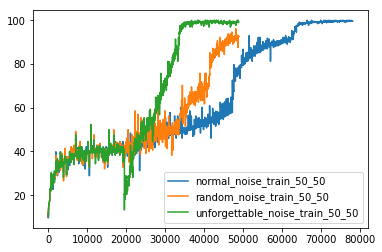

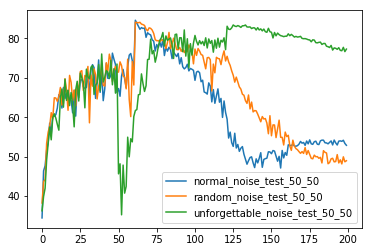

In [31]:
def train_on_noise_dataset():
    out_dir = './online_results'
    fig_cnt = 0
    for noise_percent in [30, 40, 50]:
        for remove_percent in [30, 40, 50]:
            remove_n = int(50000 * remove_percent / 100)
            stats = {}
            stats['normal'] = get_stats(out_dir, noise_percent_labels=noise_percent, remove_n=remove_n, remove_strategy='normal')
            stats['random'] = get_stats(out_dir, noise_percent_labels=noise_percent, remove_n=remove_n, remove_strategy='random')
            stats['unforgettable'] = get_stats(out_dir, noise_percent_labels=noise_percent, remove_n=remove_n, remove_strategy='unforgettable')
            
            # plot figure
            fig_cnt += 1
            plt.figure(fig_cnt)
            for key in stats:
                label = '_'.join([key, 'noise_train', str(noise_percent), str(remove_percent)])
                plt.plot(stats[key]['train'][1], label=label)
            plt.legend()
            
            fig_cnt += 1
            plt.figure(fig_cnt)
            for key in stats:
                label = '_'.join([key, 'noise_test', str(noise_percent), str(remove_percent)])
                plt.plot(stats[key]['test'][1], label=label)
            plt.legend()
            
    plt.show()
    
train_on_noise_dataset()

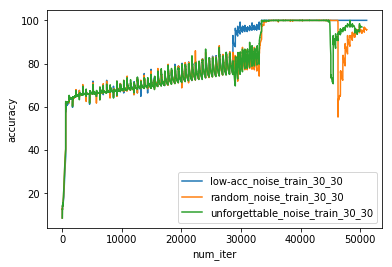

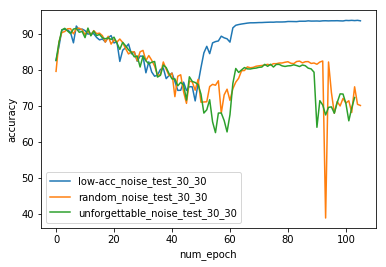

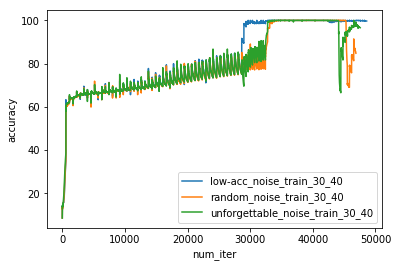

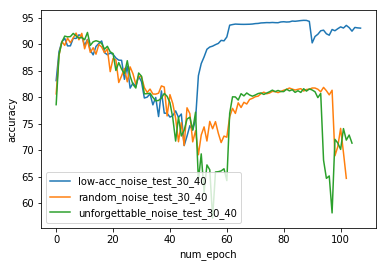

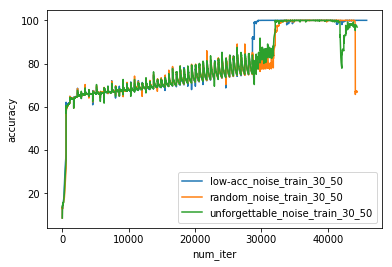

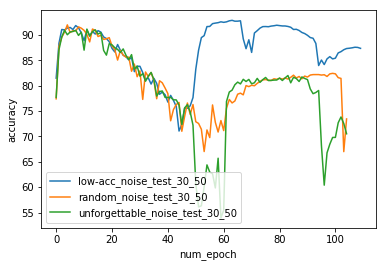

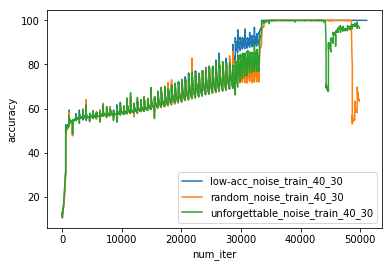

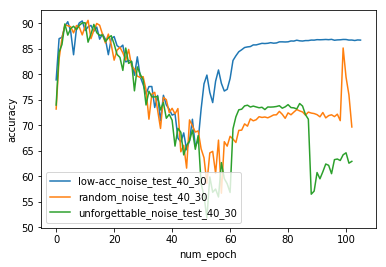

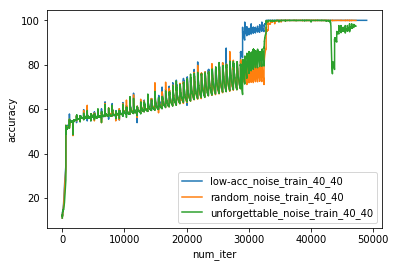

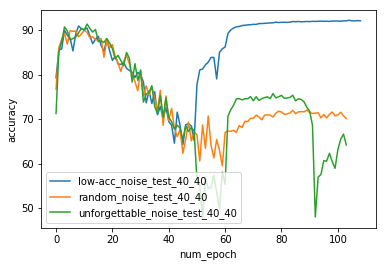

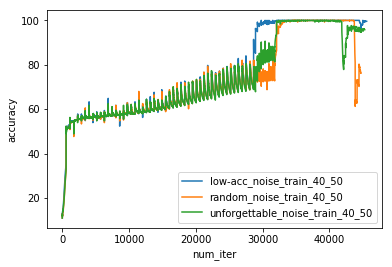

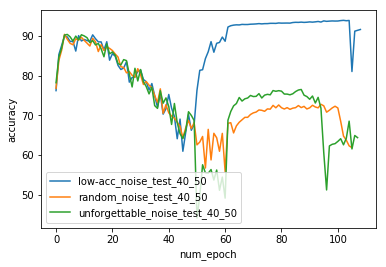

In [40]:
def train_on_noise_svhn():
    out_dir = './online_results'
    dataset = 'svhn'
    fig_cnt = 0
    def plot():
        stats = {}
        stats['random'] = get_stats(out_dir, dataset='svhn', noise_percent_labels=noise_percent, remove_percent=remove_percent, remove_strategy='random')
        stats['unforgettable'] = get_stats(out_dir, dataset='svhn', noise_percent_labels=noise_percent, remove_percent=remove_percent, remove_strategy='unforgettable')
        stats['low-acc'] = get_stats(out_dir, dataset='svhn', noise_percent_labels=noise_percent, remove_percent=remove_percent, remove_strategy='low-acc')

        # plot figure
        #fig_cnt += 1
        plt.figure()
        for key in stats:
            label = '_'.join([key, 'noise_train', str(noise_percent), str(remove_percent)])
            plt.plot(stats[key]['train'][1], label=label)
            plt.xlabel('num_iter')
            plt.ylabel('accuracy')
        plt.legend()

        #fig_cnt += 1
        plt.figure()
        for key in stats:
            label = '_'.join([key, 'noise_test', str(noise_percent), str(remove_percent)])
            plt.plot(stats[key]['test'][1], label=label)
            plt.xlabel('num_epoch')
            plt.ylabel('accuracy')
        plt.legend()

        plt.show()
        

    for noise_percent in [30, 40]:
        for remove_percent in [30, 40, 50]:
            try:
                plot()
            except EOFError:
                continue
    
train_on_noise_svhn()

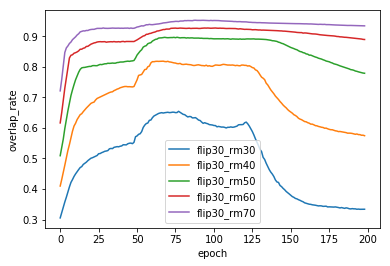

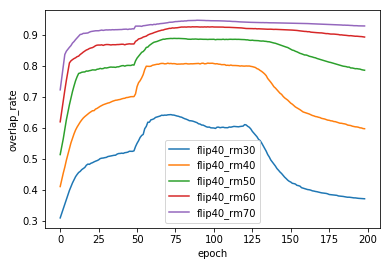

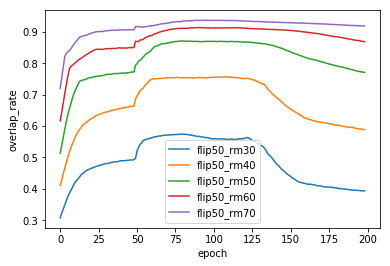

In [9]:
def analyze_overlap1():
    # analyze the overlap between removed data and flipped data
    out_dir = './online_results'
    fig_cnt = 0
    num_samples = 50000
    epochs = 200
    for noise_percent in [30, 40, 50]:
        fig_cnt += 1
        plt.figure(fig_cnt)
        for remove_percent in [30, 40, 50, 60, 70]:
            remove_n = int(num_samples * remove_percent / 100)
            stats = get_stats(out_dir, noise_percent_labels=noise_percent, remove_percent=remove_percent, remove_strategy='unforgettable')
            flipped = get_flipped_data(out_dir, noise_percent_labels=noise_percent, remove_percent=remove_percent, remove_strategy='unforgettable')
            
            counting = []
            for idx in range(num_samples):
                acc = np.array(stats[idx][1]) # (200, )
                events = (acc[1:] - acc[:-1]) == -1
                cnt = np.cumsum(events)
                counting.append(cnt)
            counting = np.stack(counting, axis=1)
            rates = []
            for epoch in range(counting.shape[0]):
                cnt = counting[epoch]
                removed = np.argsort(cnt)[:remove_n]
                rate = len(np.intersect1d(removed, flipped)) / len(flipped)
                rates.append(rate)
            plt.xlabel('epoch')
            plt.ylabel('overlap_rate')
            plt.plot(rates,label='_'.join(['flip' + str(noise_percent), 'rm' + str(remove_percent)]))
        plt.legend()               
        plt.show()

        
analyze_overlap1()           

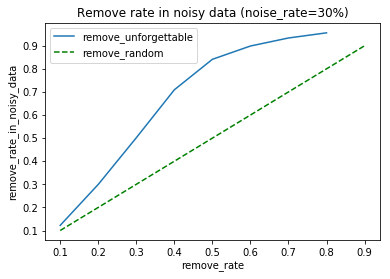

In [130]:
def analyze_overlap2():
    # analyze the overlap between removed data and flipped data
    out_dir = './online_results'
    fig_cnt = 0
    num_samples = 50000
    epochs = 200
    remove_percents = [10, 20, 30, 40, 50, 60, 70, 80]
    for noise_percent in [30]:
        remove_rates = []
        for remove_percent in remove_percents:
            remove_n = int(num_samples * remove_percent / 100)
            stats = get_stats(out_dir, noise_percent_labels=noise_percent, remove_percent=remove_percent, remove_strategy='unforgettable')
            flipped = get_flipped_data(out_dir, noise_percent_labels=noise_percent, remove_percent=remove_percent, remove_strategy='unforgettable')
            
            counting = []
            for idx in range(num_samples):
                acc = np.array(stats[idx][1]) # (200, )
                events = (acc[1:] - acc[:-1]) == -1
                cnt = np.cumsum(events)
                counting.append(cnt)
            counting = np.stack(counting, axis=1)
            rates = []
            for epoch in range(counting.shape[0]):
                cnt = counting[epoch]
                removed = np.argsort(cnt)[:remove_n]
                rate = len(np.intersect1d(removed, flipped)) / len(flipped)
                rates.append(rate)
            avg_rate = sum(rates) / len(rates)
            remove_rates.append(avg_rate)
        
        plt.plot([x / 100 for x in remove_percents], remove_rates, label='remove_unforgettable')
        plt.legend()
    
    plt.plot([x / 10 for x in range(1, 10)], [x / 10 for x in range(1, 10)], 'g--', label='remove_random')
    plt.legend()
    plt.xlabel('remove_rate')
    plt.ylabel('remove_rate_in_noisy_data')
    plt.xticks([x / 10 for x in range(1, 10)])
    plt.yticks([x / 10 for x in range(1, 10)])
    plt.title('Remove rate in noisy data (noise_rate=30%)')
    plt.show()
     
analyze_overlap2()

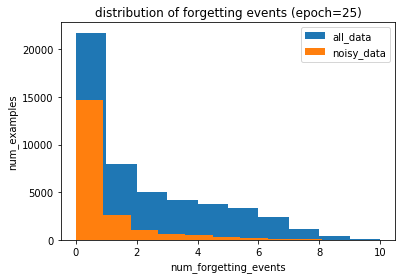

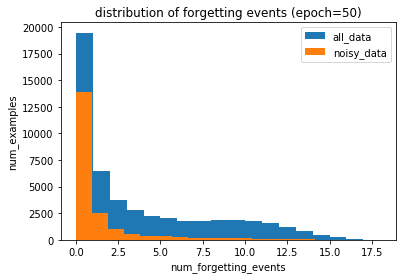

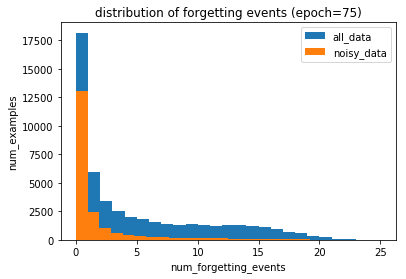

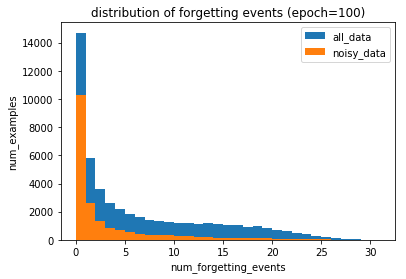

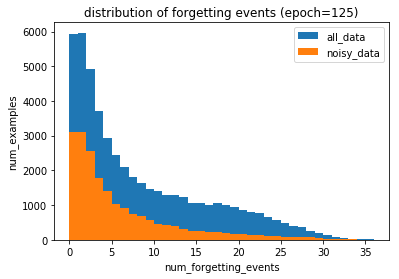

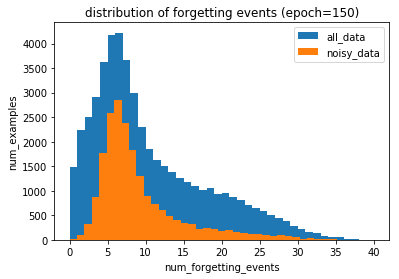

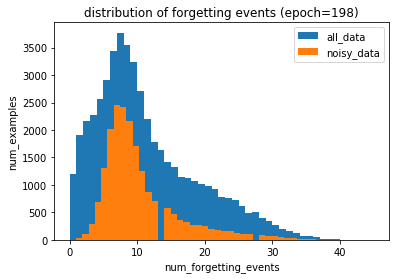

In [131]:
def forgetting_dist_across_epochs():
    out_dir = './online_results'
    fig_cnt = 0
    num_samples = 50000
    epochs = 200
    strategy = 'normal'
    for noise_percent in [40]:
        fig_cnt += 1
        plt.figure(fig_cnt)
        for remove_percent in [40]:
            remove_n = int(num_samples * remove_percent / 100)
            stats = get_stats(out_dir, noise_percent_labels=noise_percent, remove_percent=remove_percent, remove_strategy=strategy)
            flipped = get_flipped_data(out_dir, noise_percent_labels=noise_percent, remove_percent=remove_percent, remove_strategy=strategy)
            unflipped = np.setdiff1d(range(num_samples), flipped)

            counting = []
            for idx in range(num_samples):
                acc = np.array(stats[idx][1]) # (200, )
                events = (acc[1:] - acc[:-1]) == -1
                cnt = np.cumsum(events)
                counting.append(cnt)
            counting = np.stack(counting, axis=1)
            # counting: (200, 50000)
            for epoch in [25, 50, 75, 100, 125, 150, 198]:
                cnt = counting[epoch]
                plt.hist(cnt, bins=max(cnt), label='all_data')
                # plt.hist(cnt[unflipped], bins=max(cnt))
                plt.hist(cnt[flipped], bins=max(cnt), label='noisy_data')
                plt.legend()
                plt.xlabel('num_forgetting_events')
                plt.ylabel('num_examples')
                plt.title('distribution of forgetting events (epoch={0})'.format(epoch))
                plt.show()

forgetting_dist_across_epochs()

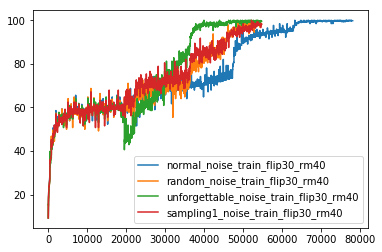

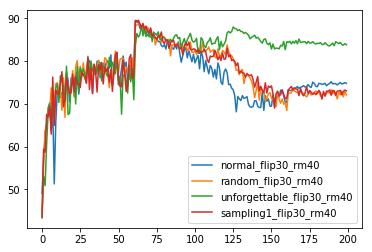

In [136]:
def compare_sampling_on_noise_dataset():
    out_dir = './online_results'
    fig_cnt = 0
    strategy = 'sampling1'
    for noise_percent in [30]:
        for remove_percent in [40]:
            remove_n = int(50000 * remove_percent / 100)
            stats = {}
            stats['normal'] = get_stats(out_dir, noise_percent_labels=noise_percent, remove_percent=remove_percent, remove_strategy='normal')
            stats['random'] = get_stats(out_dir, noise_percent_labels=noise_percent, remove_percent=remove_percent, remove_strategy='random')
            stats['unforgettable'] = get_stats(out_dir, noise_percent_labels=noise_percent, remove_percent=remove_percent, remove_strategy='unforgettable')
            stats[strategy] = get_stats(out_dir, noise_percent_labels=noise_percent, remove_percent=remove_percent, remove_strategy=strategy)

            # plot figure
            fig_cnt += 1
            plt.figure(fig_cnt)
            for key in stats:
                label = '_'.join([key, 'noise_train', 'flip' + str(noise_percent), 'rm' + str(remove_percent)])
                plt.plot(stats[key]['train'][1], label=label)
            plt.legend()
            
            fig_cnt += 1
            plt.figure(fig_cnt)
            for key in stats:
                label = '_'.join([key, 'flip' + str(noise_percent), 'rm' + str(remove_percent)])
                plt.plot(stats[key]['test'][1], label=label)
            plt.legend()
            
    plt.show()
    
compare_sampling_on_noise_dataset()

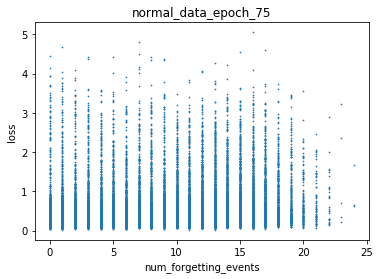

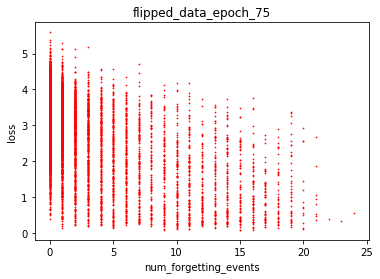

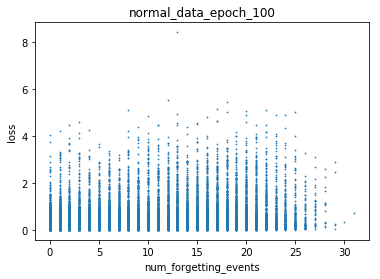

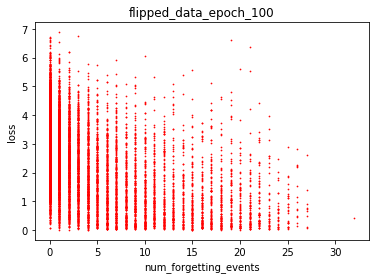

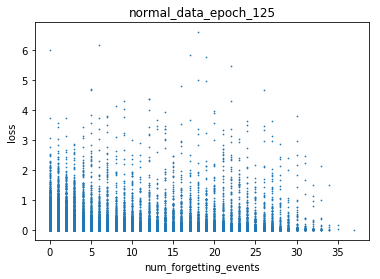

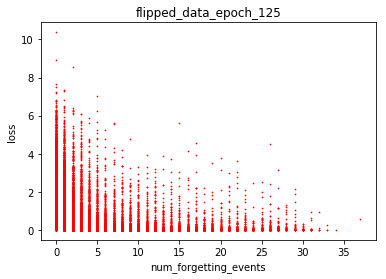

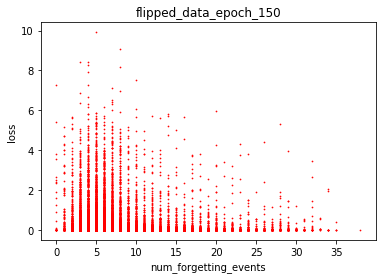

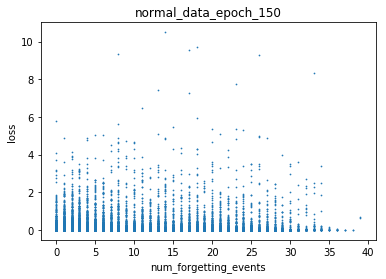

In [30]:
def dist_two_dimension():
    out_dir = './online_results'
    remove_percent = 40
    noise_percent = 30
    stats = get_stats(out_dir, noise_percent_labels=noise_percent, remove_percent=remove_percent, remove_strategy='normal')
    flipped_indexes = get_flipped_data(out_dir, noise_percent_labels=noise_percent, remove_percent=remove_percent, remove_strategy='normal')

    fig_cnt = 1
    for epoch in [75, 100, 125, 150]:
        example_losses = []
        example_events = []
    
        for idx in range(50000):
            loss, acc, _ = stats[idx]
            acc = np.array(acc)
            example_losses.append(loss[epoch])                
            events = (acc[1:epoch] - acc[0:epoch-1]) == -1
            cnt = np.sum(events)
            example_events.append(cnt)
        example_losses = np.array(example_losses)
        example_events = np.array(example_events)

        normal_indexes = np.setdiff1d(range(50000), flipped_indexes)
        s = 0.5
        plt.figure(fig_cnt)
        fig_cnt += 1
        plt.scatter(example_events[normal_indexes], example_losses[normal_indexes], s=s)
        plt.title('normal_data_epoch_{0}'.format(epoch))
        plt.xlabel('num_forgetting_events')
        plt.ylabel('loss')
        plt.figure(fig_cnt)
        fig_cnt += 1
        plt.scatter(example_events[flipped_indexes], example_losses[flipped_indexes], c='red', s=s)
        plt.title('flipped_data_epoch_{0}'.format(epoch))
        plt.xlabel('num_forgetting_events')
        plt.ylabel('loss')
        plt.show()

dist_two_dimension()

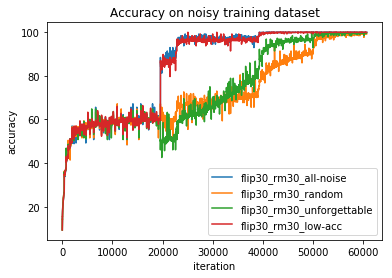

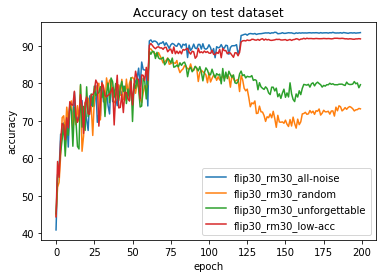

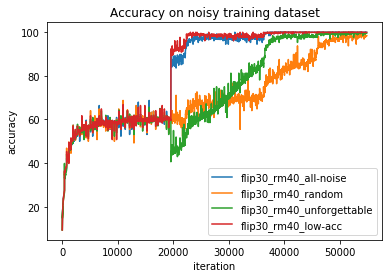

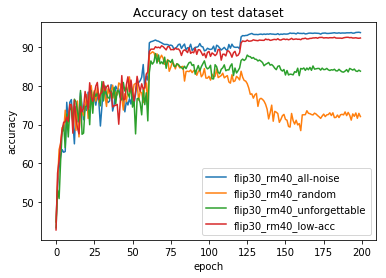

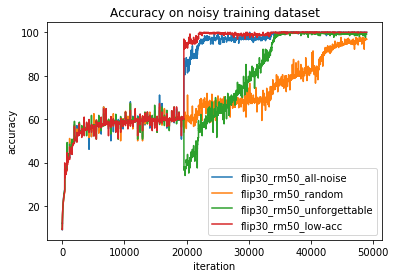

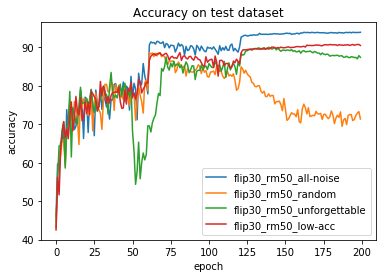

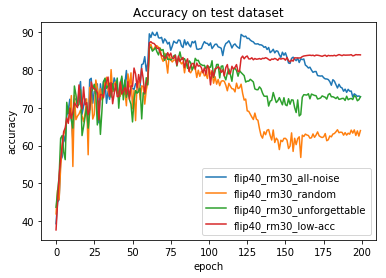

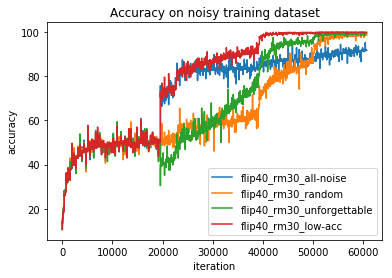

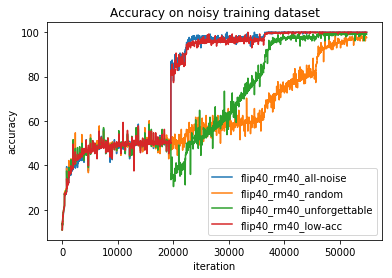

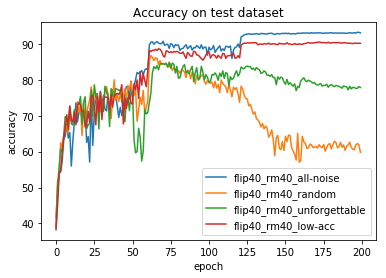

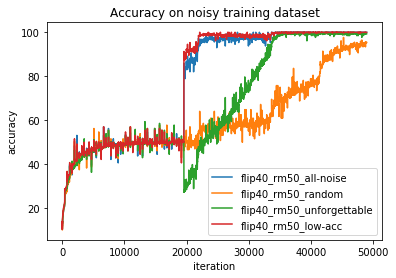

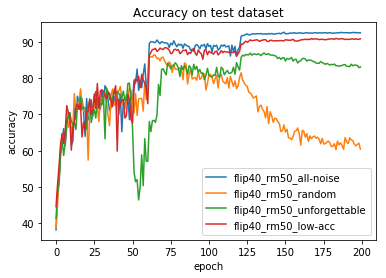

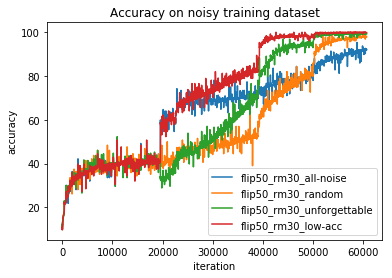

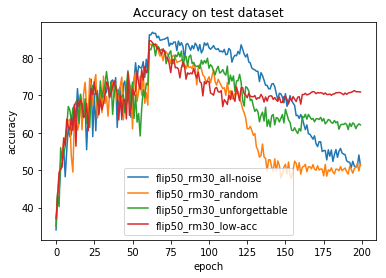

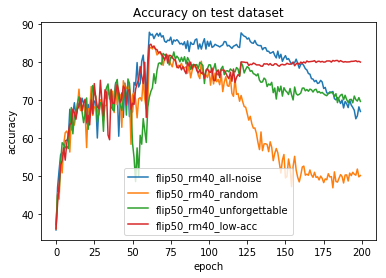

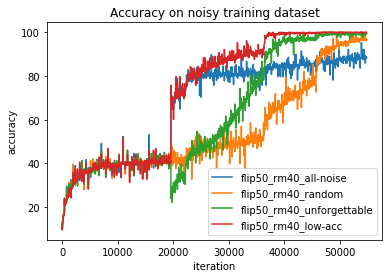

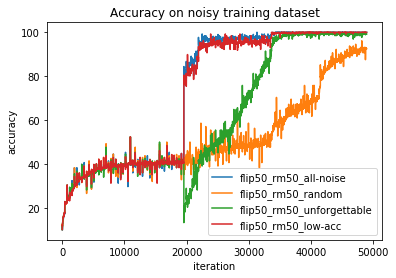

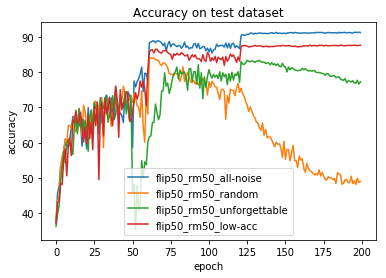

In [142]:
def compare_remove_low_acc():
    out_dir = './online_results'
    fig_cnt = 0
    strategy = 'low-acc'
    for noise_percent in [30, 40, 50]:
        for remove_percent in [30, 40, 50]:
            remove_n = int(50000 * remove_percent / 100)
            stats = {}
            # stats['normal'] = get_stats(out_dir, noise_percent_labels=noise_percent, remove_percent=remove_percent, remove_strategy='normal')
            stats['random'] = get_stats(out_dir, noise_percent_labels=noise_percent, remove_percent=remove_percent, remove_strategy='random')
            stats['unforgettable'] = get_stats(out_dir, noise_percent_labels=noise_percent, remove_percent=remove_percent, remove_strategy='unforgettable')
            stats['low-acc'] = get_stats(out_dir, noise_percent_labels=noise_percent, remove_percent=remove_percent, remove_strategy='low-acc')            
            stats['all-noise'] = get_stats(out_dir, noise_percent_labels=noise_percent, remove_percent=remove_percent, remove_strategy='all-noise')

            # plot figure
            fig_cnt += 1
            plt.figure(fig_cnt)
            for key in stats:
                label = '_'.join(['flip' + str(noise_percent), 'rm' + str(remove_percent), key])
                plt.plot(stats[key]['train'][1], label=label)
            plt.xlabel('iteration')
            plt.ylabel('accuracy')
            plt.title('Accuracy on noisy training dataset')
            plt.legend()
            
            fig_cnt += 1
            plt.figure(fig_cnt)
            for key in stats:
                label = '_'.join(['flip' + str(noise_percent), 'rm' + str(remove_percent), key])
                plt.plot(stats[key]['test'][1], label=label)
                plt.xlabel('epoch')
                plt.ylabel('accuracy')
            plt.title('Accuracy on test dataset')
            plt.legend()
            
            plt.show()
    
compare_remove_low_acc()

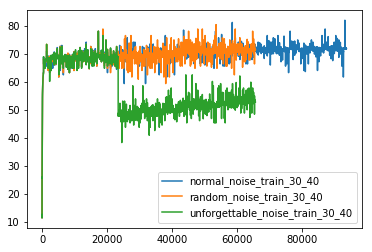

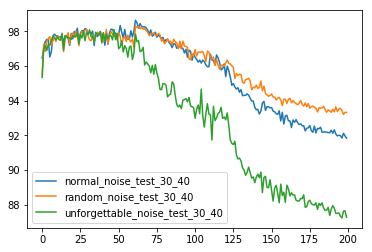

In [69]:
def train_cifar100_on_noise_dataset():
    out_dir = './online_results'
    fig_cnt = 0
    dataset = 'mnist'
    for noise_percent in [30]:
        for remove_percent in [40]:
            stats = {}
            stats['normal'] = get_stats(out_dir, dataset=dataset, noise_percent_labels=noise_percent, remove_percent=remove_percent, remove_strategy='normal')
            stats['random'] = get_stats(out_dir, dataset=dataset, noise_percent_labels=noise_percent, remove_percent=remove_percent, remove_strategy='random')
            stats['unforgettable'] = get_stats(out_dir, dataset=dataset, noise_percent_labels=noise_percent, remove_percent=remove_percent, remove_strategy='unforgettable')
            
            # plot figure
            fig_cnt += 1
            plt.figure(fig_cnt)
            for key in stats:
                label = '_'.join([key, 'noise_train', str(noise_percent), str(remove_percent)])
                plt.plot(stats[key]['train'][1], label=label)
            plt.legend()
            
            fig_cnt += 1
            plt.figure(fig_cnt)
            for key in stats:
                label = '_'.join([key, 'noise_test', str(noise_percent), str(remove_percent)])
                plt.plot(stats[key]['test'][1], label=label)
            plt.legend()
            
            plt.show()
    
train_cifar100_on_noise_dataset()

In [ ]:
def compare_different_mode():
    # compare different mode: normal, pretrained, online
    normal_stats = get_data_stats()
    pass

In [ ]:
def compare_once_different_burn_in_epochs():
    fname1 = 'origin_seed_1.pkl'
    fname2 = 'remove_seed_1.pkl'
    fname3 = 'online.pkl'
    
    plt.figure(1)
    with open(fname1, 'rb') as fin:
        data_stats = pickle.load(fin)
        plt.plot(data_stats['train'][1], label='origin_train')
    with open(fname2, 'rb') as fin:
        data_stats = pickle.load(fin)
        plt.plot(data_stats['train'][1], label='remove_train')
    with open(fname3, 'rb') as fin:
        data_stats = pickle.load(fin)
        plt.plot(data_stats['train'][1], label='online_train')
    plt.legend()
    
    plt.figure(2)
    with open(fname1, 'rb') as fin:
        data_stats = pickle.load(fin)
        plt.plot(data_stats['test'][1], label='origin_test_epoch')
    with open(fname2, 'rb') as fin:
        data_stats = pickle.load(fin)
        plt.plot(data_stats['test'][1], label='remove_test_epoch')
    with open(fname3, 'rb') as fin:
        data_stats = pickle.load(fin)
        plt.plot(data_stats['test'][1], label='online_test_epoch')
    plt.legend()

    
    plt.figure(3)
    with open(fname1, 'rb') as fin:
        data_stats = pickle.load(fin)
        plt.plot([x * 391 for x in range(200)], data_stats['test'][1], label='origin_test_batch')
    with open(fname2, 'rb') as fin:
        data_stats = pickle.load(fin)
        plt.plot([x * 274 for x in range(200)], data_stats['test'][1], label='remove_test_batch')
    with open(fname3, 'rb') as fin:
        data_stats = pickle.load(fin)
        x_data = []
        counter = 0
        for i in range(200):
            if i < 50:
                counter += 391
            else:
                counter += 274
            x_data.append(counter)
        plt.plot(x_data, data_stats['test'][1], label='online_test_batch')
    plt.legend()
    plt.show()

In [ ]:
def compare_normal_and_post():
    # prepare stats
    data_dir = './online_results'
    origin_stats = get_stats(data_dir)
    post_stats = get_stats(data_dir, mode='pretrained')
        
    plt.figure(1)
    plt.plot(origin_stats['train'][1], label='origin_train')
    plt.plot(post_stats['train'][1], label='post_train')
    plt.legend()
    
    plt.figure(2)
    plt.plot(origin_stats['test'][1], label='origin_test_epoch')
    plt.plot(post_stats['test'][1], label='post_test_epoch')
    plt.legend()
    
    plt.figure(3)
    plt.plot([x * 391 for x in range(200)], origin_stats['test'][1], label='origin_test_batch')
    plt.plot([x * 277 for x in range(200)], post_stats['test'][1], label='post_test_batch')
    plt.legend()
    
    plt.show()

compare_normal_and_post()

In [ ]:
def compare_post_across_seed():
    for d, _, fs in os.walk('./cifar10_results'):
        for f in fs:
            if f.endswith('stats_dict.pkl'):
                print('including file: ' + f)

                with open(os.path.join(d, f), 'rb') as fin:
                    # dict[example_id] -> [loss, acc, margin] (list of epochs)
                    loaded = pickle.load(fin)


def compare_post_and_online():
    d = './cifar10_results'
    f = 'cifar10_sorted.pkl'

    with open(os.path.join(d, f), 'rb') as fin:
        loaded = pickle.load(fin)

    print(loaded)
    trained_indices = loaded['indices']

    with open('online.pkl', 'rb') as f:
        online_indices = pickle.load(f)

    print(trained_indices)
    print(online_indices)

    from scipy.stats import kendalltau

    # Kendall-Tau correclation
    kendalltau_result = kendalltau(trained_indices, online_indices)
    print(kendalltau_result)

    # Ranked-bias Overlap
    # quite slow
    from rbo import rbo

    rbo_result = rbo(trained_indices, online_indices, p=0.9)
    print(rbo_result)
    
    
